In [17]:
import re
import sys

def extract_significant_neurons(filepath, threshold=0.1):
    significant = []
    pattern = re.compile(r"Neuron\s+(\d+):\s+R²\s+\(probs\)\s+=\s+([-+]?\d*\.\d+|\d+)")
    
    with open(filepath, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                neuron_idx = int(match.group(1))
                r2 = float(match.group(2))
                if r2 > threshold:
                    significant.append(neuron_idx)

    return significant


sig_neurons = extract_significant_neurons(filepath='/home/maria/LuckyMouse2/mo/neurons.txt')
len(sig_neurons)


2261

In [16]:
import pickle
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from tqdm import tqdm

# ─── Load Data ───────────────────────────────────────────────────────────────
dataset_path_dict = {
    "embeddings": "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl",
    "neural": "/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy"  # trial-wise binary spikes
}

with open(dataset_path_dict['embeddings'], "rb") as f:
    embeddings_raw = pickle.load(f)
embeddings = embeddings_raw['natural_scenes']  # shape: (118, 1000)
print("Full embedding shape:", embeddings.shape)

neural_data = np.load(dataset_path_dict["neural"])  # shape: (neurons, 5900)
print("Neural data shape:", neural_data.shape)

# ─── Construct Trial-wise Design Matrix ──────────────────────────────────────
n_images = embeddings.shape[0]        # 118
n_trials = 50
n_total = n_images * n_trials         # 5900

X_all = np.repeat(embeddings, n_trials, axis=0)  # shape: (5900, 1000)


# ─── Fit Models and Store Coefficients ───────────────────────────────────────
coeff_matrix = []

for neuron_idx in tqdm(sig_neurons, desc="Fitting significant neurons"):
    y_all = neural_data[neuron_idx]  # shape: (5900,)
    model = LogisticRegression(solver="liblinear", max_iter=1000)
    model.fit(X_all, y_all)
    coeff_matrix.append(model.coef_.flatten())  # shape: (1000,)

coeff_matrix = np.stack(coeff_matrix)  # shape: (n_sig_neurons, 1000)
print(f"Final coefficient matrix shape: {coeff_matrix.shape}")

# ─── Save to Disk ────────────────────────────────────────────────────────────
np.save("logreg_coefficients_sig_neurons.npy", coeff_matrix)
print("Saved coefficients to logreg_coefficients_sig_neurons.npy")

Full embedding shape: (118, 1000)
Neural data shape: (39209, 5900)


Fitting significant neurons:   0%|          | 0/2261 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [19]:
sig_neurons

[23,
 54,
 160,
 179,
 200,
 207,
 211,
 226,
 231,
 243,
 270,
 290,
 292,
 296,
 304,
 308,
 312,
 322,
 325,
 329,
 332,
 335,
 346,
 354,
 355,
 376,
 395,
 402,
 404,
 416,
 433,
 440,
 443,
 454,
 458,
 478,
 483,
 492,
 501,
 506,
 517,
 563,
 580,
 593,
 596,
 606,
 615,
 623,
 657,
 664,
 671,
 673,
 675,
 692,
 718,
 731,
 743,
 762,
 773,
 777,
 799,
 805,
 826,
 835,
 843,
 865,
 882,
 903,
 912,
 940,
 950,
 970,
 974,
 976,
 988,
 996,
 1010,
 1022,
 1031,
 1045,
 1046,
 1052,
 1067,
 1068,
 1071,
 1073,
 1075,
 1079,
 1095,
 1096,
 1099,
 1105,
 1114,
 1117,
 1121,
 1126,
 1134,
 1139,
 1151,
 1156,
 1162,
 1168,
 1191,
 1204,
 1218,
 1229,
 1230,
 1236,
 1245,
 1249,
 1262,
 1273,
 1275,
 1290,
 1297,
 1300,
 1319,
 1330,
 1337,
 1338,
 1342,
 1343,
 1347,
 1359,
 1370,
 1377,
 1404,
 1407,
 1421,
 1422,
 1425,
 1426,
 1429,
 1474,
 1485,
 1503,
 1507,
 1524,
 1535,
 1566,
 1594,
 1622,
 1652,
 1656,
 1735,
 1752,
 1761,
 1762,
 1767,
 1783,
 1802,
 1834,
 1846,
 1981,


In [13]:
from collections import defaultdict

coeffs_by_area = defaultdict(list)
area_labels=np.load('/home/maria/LuckyMouse4/src/allen_validation/sig_neuron_areas.npy')
for i, neuron_idx in enumerate(sig_neurons):
    area = area_labels[i]
    if area != "Unknown":
        coeffs_by_area[area].append(coeff_matrix[i])

# Convert lists to arrays
coeffs_by_area = {k: np.stack(v) for k, v in coeffs_by_area.items()}

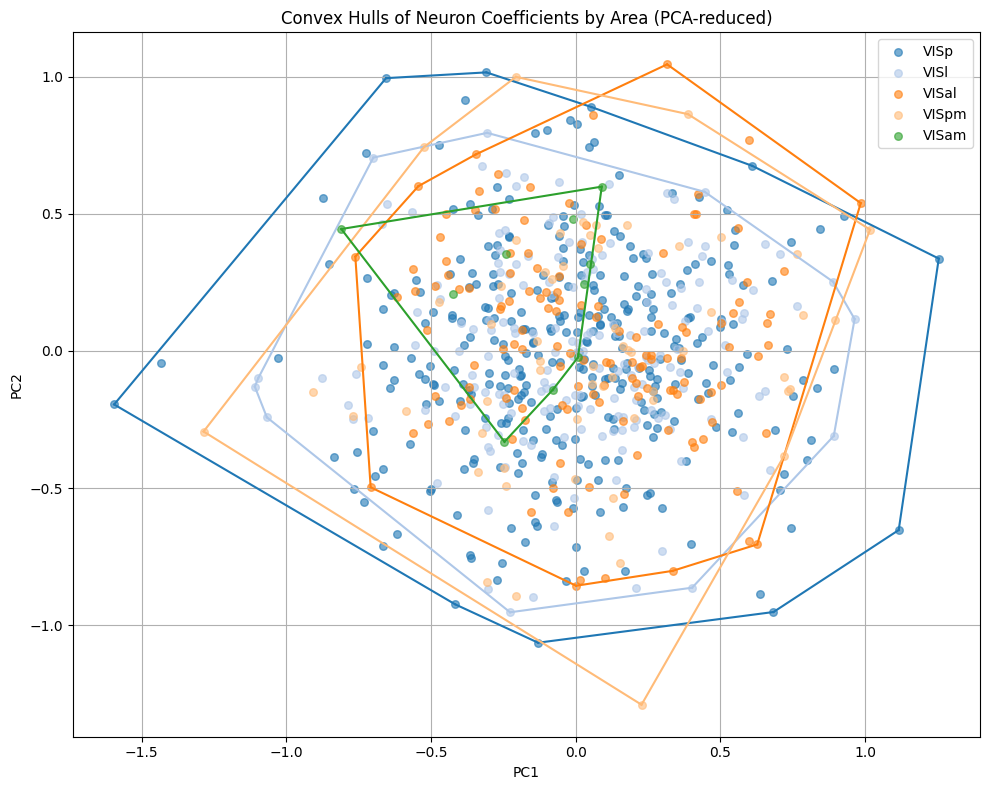

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from collections import defaultdict

# ─── Reduce to 2D and Fit Convex Hulls ───────────────────────────────────────
pca = PCA(n_components=2)
all_coeffs = np.vstack(list(coeffs_by_area.values()))
pca.fit(all_coeffs)

plt.figure(figsize=(10, 8))
colors = plt.cm.tab20.colors  # Up to 20 areas

for idx, (area, coeffs) in enumerate(coeffs_by_area.items()):
    coeffs = np.stack(coeffs)
    coeffs_2d = pca.transform(coeffs)

    # Plot points
    plt.scatter(coeffs_2d[:, 0], coeffs_2d[:, 1], s=30, alpha=0.6, label=area, color=colors[idx % len(colors)])

    # Fit convex hull if enough points
    if coeffs_2d.shape[0] >= 3:
        try:
            hull = ConvexHull(coeffs_2d)
            for simplex in hull.simplices:
                plt.plot(coeffs_2d[simplex, 0], coeffs_2d[simplex, 1], color=colors[idx % len(colors)], linewidth=1.5)
        except Exception as e:
            print(f"Convex hull failed for area {area}: {e}")

plt.title("Convex Hulls of Neuron Coefficients by Area (PCA-reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()